In [20]:
import cv2
import easyocr
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from langdetect import detect
import symspellpy
from symspellpy import SymSpell
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# Initialize TrOCR
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# EasyOCR for text detection
reader = easyocr.Reader(['nl'], gpu=torch.cuda.is_available())

# Language-specific SymSpell instances
sym_spell_dicts = {
    "en": "frequency_dictionary_en_82_765.txt",
    # "de": "frequency_dictionary_de_100_000.txt",
}

def init_symspell(lang):
    sym_spell = SymSpell()
    if lang in sym_spell_dicts:
        sym_spell.load_dictionary(sym_spell_dicts[lang], 0, 1)
    return sym_spell

def detect_text(image_path):
    """ Detect text regions using EasyOCR """
    image = cv2.imread(image_path)
    results = reader.detect(image)
    boxes = results[0][0]
    cropped_regions = []

    for box in boxes:
        x_min, x_max, y_min, y_max = box
        cropped = image[y_min:y_max, x_min:x_max]
        cropped_regions.append(cropped)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    colored_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(colored_image)
    plt.title("Detected Text Regions")
    plt.axis("off")

    # Write image with detected boxes to jpg file
    cv2.imwrite(f"{Path(image_path).parts[-1]}_detected_text_regions.jpg", colored_image)

    plt.show()
    
    return cropped_regions

def recognize_text(cropped_regions):
    """ Recognize text with TrOCR """
    texts = []
    for i, region in enumerate(cropped_regions):
        region = cv2.cvtColor(region, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(region).convert("RGB")
        # save pil_image to file
        pil_image.save(f"cropped region {i}.jpg")

        pixel_values = processor(pil_image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        texts.append(text)
    return texts

def correct_text(text):
    """ Detect language and apply SymSpell corrections """
    try:
        language = detect(text)
        if language in sym_spell_dicts:
            sym_spell = init_symspell(language)
            suggestions = sym_spell.lookup(text, symspellpy.Verbosity.CLOSEST, max_edit_distance=2)
            return suggestions[0].term if suggestions else text
        else:
            return text
    except:
        return text

def process_image(image_path, output_folder: Path):
    cropped_regions = detect_text(image_path)
    recognized_texts = recognize_text(cropped_regions)

    return recognized_texts

    # Save raw recognized text to file
    with open(output_folder / f"{Path(image_path).parts[-1]}_recognized_text.txt", "w") as f:
        for text in recognized_texts:
            f.write(f"{text}\n")
    

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decode

0it [00:00, ?it/s]


Processing image: ../images/processed-8421C2D1-9DB9-4A9A-B200-A831FC833F85.jpg


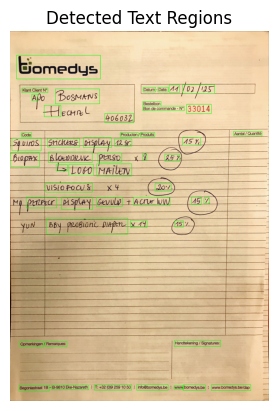

0it [00:33, ?it/s]

['</s>tiomedys</s>', '</s>kiant client No</s>', '</s>datum .</s>', '</s>date :</s>', '</s>11</s>', '</s>1021125</s>', '</s>a ,</s>', '</s>bosmans .</s>', '</s>bestelbon .</s>', '</s>Bon de commande - No</s>', '</s>33014</s>', '</s>h.</s>', '</s>406032</s>', '</s>code .</s>', '</s>production .</s>', '</s>products</s>', '</s>Aantal ( Quantite</s>', '</s>squiros .</s>', '</s>srichters .</s>', '</s>display</s>', '</s>12sr.</s>', '</s>15yi</s>', '</s>blephyx</s>', '</s>bloomside .</s>', '</s>penso</s>', '</s>if</s>', "</s>25'</s>", '</s>ts</s>', '</s>1060</s>', '</s>mailen .</s>', '</s>visiofocus .</s>', '</s>20.</s>', '</s>preeder .</s>', '</s>pisbury .</s>', '</s>axvulp .</s>', '</s>acrue win .</s>', '</s>15</s>', '</s>1.</s>', '</s>boy propionic drapen .</s>', '</s>xly</s>', '</s>15</s>', '</s>oppmerkingen .</s>', '</s>remarques .</s>', '</s>Handtekening , Signatures :</s>', '</s>Begoniastraat 1B.</s>', '</s>B-9810 Eke-Nazareth</s>', '</s>TI-332 ( 0/92591050</s>', '</s>infobberedysis .be

In [21]:
INPUT_FOLDER = Path("../images")
OUTPUT_FOLDER = Path("output/test_3")

for image_path in tqdm(INPUT_FOLDER.glob("*.png")):
    image_path = Path("../images/processed-8421C2D1-9DB9-4A9A-B200-A831FC833F85.jpg")
    print(f"\nProcessing image: {image_path}")
    result = process_image(image_path, OUTPUT_FOLDER)
    print(result)
    break

In [22]:
for text in result:
    print(text)

</s>tiomedys</s>
</s>kiant client No</s>
</s>datum .</s>
</s>date :</s>
</s>11</s>
</s>1021125</s>
</s>a ,</s>
</s>bosmans .</s>
</s>bestelbon .</s>
</s>Bon de commande - No</s>
</s>33014</s>
</s>h.</s>
</s>406032</s>
</s>code .</s>
</s>production .</s>
</s>products</s>
</s>Aantal ( Quantite</s>
</s>squiros .</s>
</s>srichters .</s>
</s>display</s>
</s>12sr.</s>
</s>15yi</s>
</s>blephyx</s>
</s>bloomside .</s>
</s>penso</s>
</s>if</s>
</s>25'</s>
</s>ts</s>
</s>1060</s>
</s>mailen .</s>
</s>visiofocus .</s>
</s>20.</s>
</s>preeder .</s>
</s>pisbury .</s>
</s>axvulp .</s>
</s>acrue win .</s>
</s>15</s>
</s>1.</s>
</s>boy propionic drapen .</s>
</s>xly</s>
</s>15</s>
</s>oppmerkingen .</s>
</s>remarques .</s>
</s>Handtekening , Signatures :</s>
</s>Begoniastraat 1B.</s>
</s>B-9810 Eke-Nazareth</s>
</s>TI-332 ( 0/92591050</s>
</s>infobberedysis .be</s>
</s>www</s>
</s>ibomedysibe .</s>
</s>www-bombedys .berdap</s>
